In [1]:
import pandas as pd

In [2]:
races_df = pd.read_csv('races.csv', index_col='race_id')
runs_df = pd.read_csv('runs.csv')

# Set up dataframe

create new dataframe df that we will use to train the model

### Remove unnessussary columns from runs_df

In [3]:
df = runs_df
df=df.drop('won',axis=1)
df=df.drop('horse_gear',axis=1)
df=df.drop('draw',axis=1)

# the below have too many na values
df = df.drop('horse_no', axis = 1)
df=df.drop('position_sec1',axis=1)
df=df.drop('position_sec2',axis=1)
df=df.drop('position_sec3',axis=1)
df=df.drop('position_sec4',axis=1)
df=df.drop('position_sec5',axis=1)
df=df.drop('position_sec6',axis=1)
df=df.drop('behind_sec1',axis=1)
df=df.drop('behind_sec2',axis=1)
df=df.drop('behind_sec3',axis=1)
df=df.drop('behind_sec4',axis=1)
df=df.drop('behind_sec5',axis=1)
df=df.drop('behind_sec6',axis=1)
df=df.drop('time4',axis=1)
df=df.drop('time5',axis=1)
df=df.drop('time6',axis=1)
df=df.drop('place_odds',axis=1) 

### Add relevant columns from races_df

In [4]:
df = pd.merge(df, races_df[['venue','config','surface','distance','going']], on='race_id', how='left')

### Create new columns to add to df

##### time metric columns
these columns use the time1 time2 and time3 fields to determine how much of the final time was used to run different parts of the race

In [5]:
df["time1"] = df["time1"] / df["finish_time"]
df["time2"] = df["time2"] / df["finish_time"]
df["time3"] = df["time3"] / df["finish_time"]

### Encode categorical variables

In [6]:
from sklearn import preprocessing

config_encoder = preprocessing.OrdinalEncoder()
df['config'] = config_encoder.fit_transform(df['config'].values.reshape(-1, 1))

going_encoder = preprocessing.OrdinalEncoder()
df['going'] = going_encoder.fit_transform(df['going'].values.reshape(-1, 1))

venue_encoder = preprocessing.LabelEncoder()
df['venue'] = venue_encoder.fit_transform(df['venue'])

horse_country_encoder = preprocessing.LabelEncoder()
df['horse_country'] = horse_country_encoder.fit_transform(df['horse_country'])

horse_type_encoder = preprocessing.LabelEncoder()
df['horse_type'] = horse_type_encoder.fit_transform(df['horse_type'])

only get up to race 1587

# columns

finish_time	

actual_weight	

config	

declared_weight	

distance	

going	

horse_age	

horse_country	

horse_place_perc	

horse_type	

jockey_place_perc	

time1/finising_time

time2/finising_time

time3/finising_time

surface	

trainer_place_perc	

venue

quartile = result / # horses ....

_______

result & race_id

<AxesSubplot:>

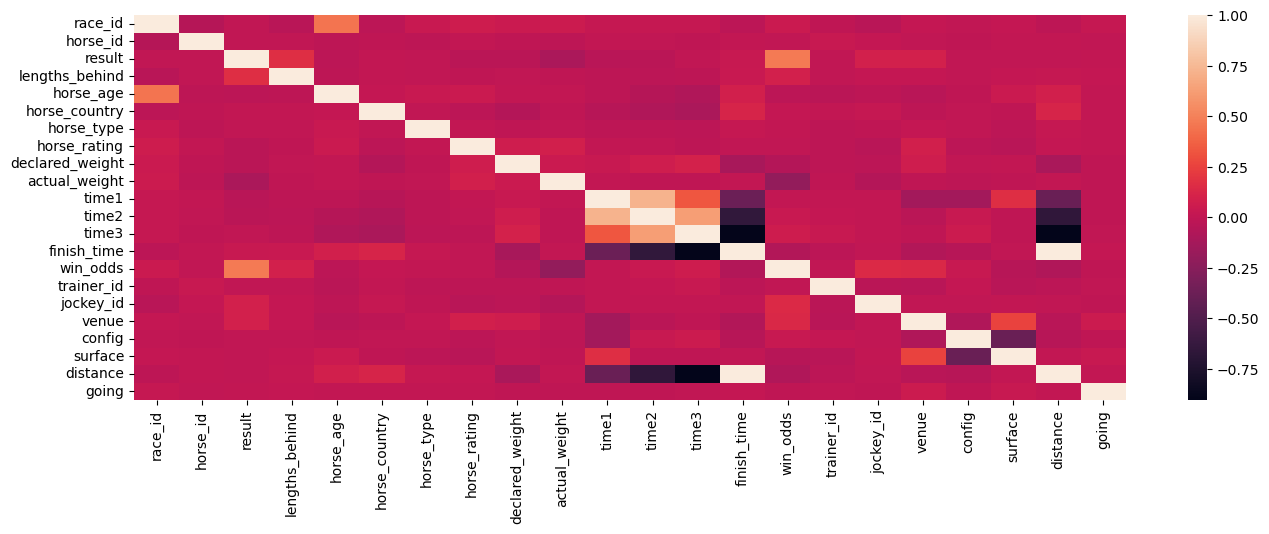

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16,5))
sns.heatmap(df.corr())

exploratory data visualization, want both uni and multivariate visualizations for analysis

more data preprocessing and cleanning

experiment with feature selection techniques

show variety of algorithms, log reg, knn, decision trees, rand forrests, ensemble techniques, SVMs (all doable with scikit learn) build NN and DNN to expieriment with different architecture of NNs, maybe take a representative sample of 20000 or so examples (carful not to lose too much info)

meet as team ASAP and make final plan 

